# Data Model - Time Series

## Initial Setup for Pyramid

In [1]:
#install pyramid for AR, ARIMA and SARIMA
!pip install pmdarima --user

## Import Library

In [2]:
#importing libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller #For ADF
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore") # ignoring annoying warnings
import pmdarima as pm
from pmdarima import model_selection
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import ExponentialSmoothing 
import math
%matplotlib inline

## Import Edited Dataset

In [3]:
#import final version of the train csv made from previous Jupyter Notebook
train_final = pd.read_csv (r'Datasets\train_final.csv')  
train_final.Date = pd.to_datetime(train_final.Date,format='%Y-%m-%d')
train_final.index = train_final.Date
train_final = train_final.drop('Date', axis=1)
train_final.head()

,Store,Dept,Weekly_Sales,IsHoliday,Type,Size,Year,Week
Date,,,,,,,,
2010-02-05,1,1,24924.50,0,3,151315,2010,5
2010-02-12,1,1,46039.49,1,3,151315,2010,6
2010-02-19,1,1,41595.55,0,3,151315,2010,7
2010-02-26,1,1,19403.54,0,3,151315,2010,8
2010-03-05,1,1,21827.90,0,3,151315,2010,9


## Setting Training and Test Set Groupby Date

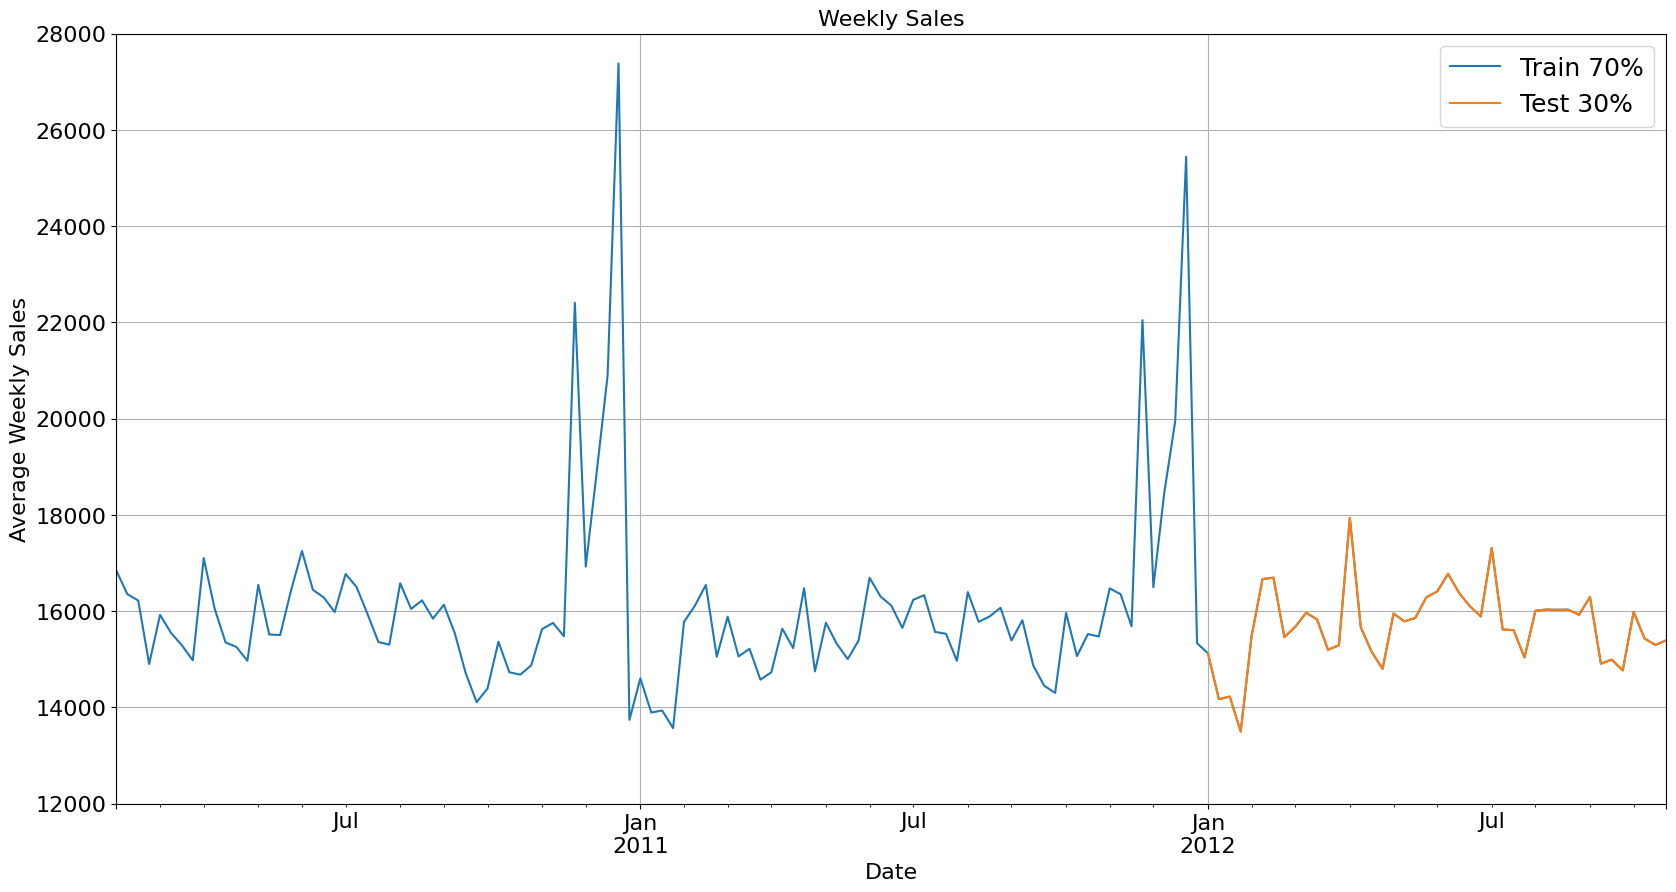

In [4]:
#Setting training and test set arranged by date order
train_final1 = train_final.groupby(train_final.index).mean()
train_finalS=train_final1['Weekly_Sales']
train_data = train_final1[:int(0.7*(len(train_final1)))]
test_data = train_final1[int(0.7*(len(train_final1))):]

train_data = train_data['Weekly_Sales']
test_data = test_data[['Weekly_Sales','IsHoliday']]

train_final1.Weekly_Sales.plot(figsize=(20,10), fontsize=16)
test_data.Weekly_Sales.plot(figsize=(20,10), fontsize=16)

plt.legend(['Train 70%','Test 30%'],loc='best',fontsize=18)
plt.title('Weekly Sales',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Average Weekly Sales',fontsize=16)
plt.ylim(12000,28000)
plt.grid(True)

plt.show()

## Decomposition of the Dataset

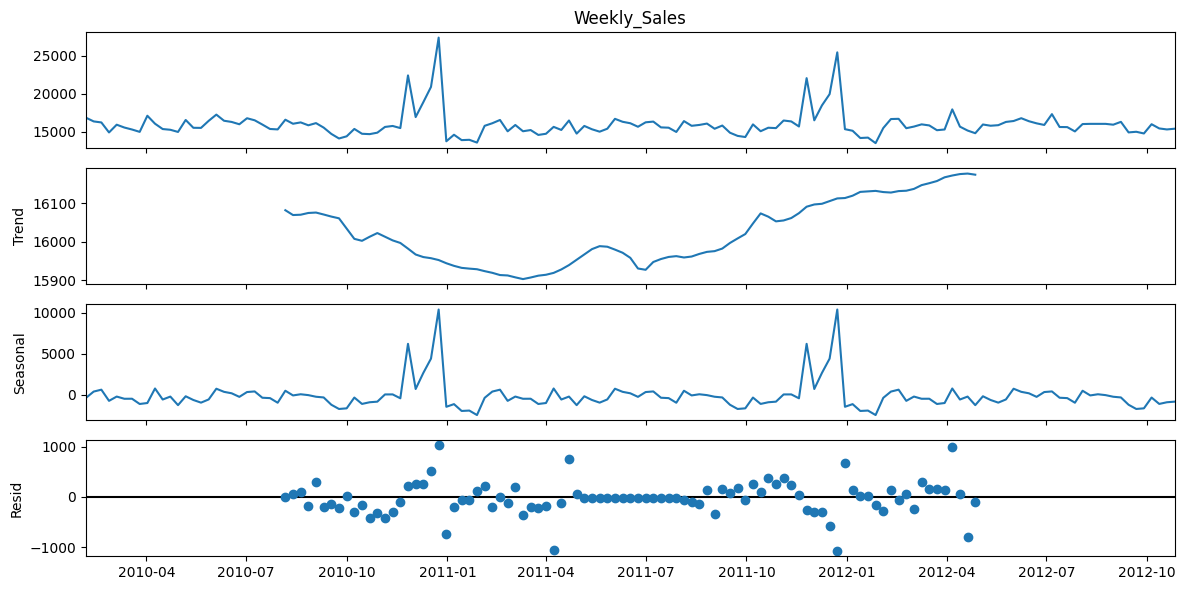

In [5]:
#Visiualing the decomposition of the data set
decomposition=seasonal_decompose(train_final1.Weekly_Sales, model= "addictive",period=52)
rcParams['figure.figsize'] = (12, 6)
fig=decomposition.plot()

This is a useful abstraction.

Decomposition is primarily used for time series analysis, and as an analysis tool it can be used to inform forecasting models on your problem.

## Augmented Dickey Fuller Test to Test Stationary

In [6]:
#Testing the dataset with Dickey Fuller test to test whether the data is stationary
X = train_final1['Weekly_Sales']
result = adfuller(X)
print('Augmented Dickey Fuller Test to Test Stationary')
print('ADF Statistic: %f' % result[0])
print('p-value: %.9f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
if result[0]<result[4]["5%"]:
    print("Reject H0, Time Series is Stationary")
else:
    print("Failed to Reject H0 Time Series is Non-Stationary")
    

Augmented Dickey Fuller Test to Test Stationary
ADF Statistic: -5.930803
p-value: 0.000000238
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Reject H0, Time Series is Stationary


- Since less than 0.5, the data is stationary
- Good to use ARIMA

## Auto Regressive Model (AR)

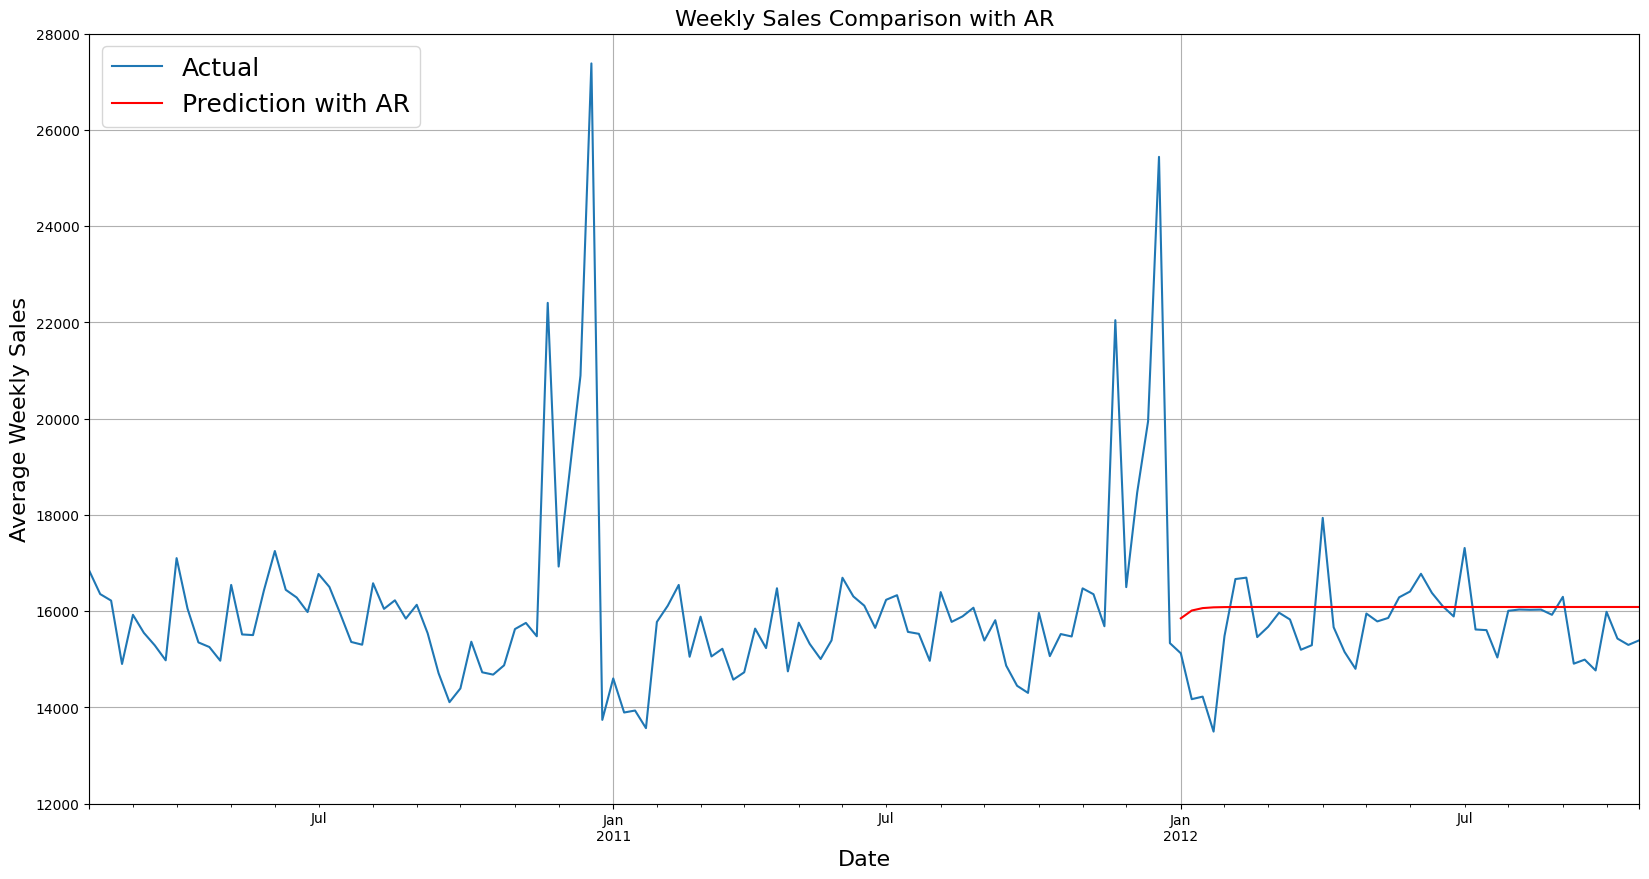

In [8]:
from statsmodels.tsa.ar_model import AutoReg

# Creating the AR model
model_ar = AutoReg(train_data, lags=1)  # Adjust the lags parameter as needed
model_ar_fit = model_ar.fit()
predictions_AR = model_ar_fit.predict(start=100, end=142)

# Plotting
train_final1['Weekly_Sales'].plot(figsize=(20, 10))
predictions_AR.plot(color="r")

plt.legend(['Actual', 'Prediction with AR'], loc=2, fontsize=18)
plt.grid(True)
plt.title('Weekly Sales Comparison with AR', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Weekly Sales', fontsize=16)
plt.ylim(12000, 28000)
plt.show()

## Moving Average (MA)

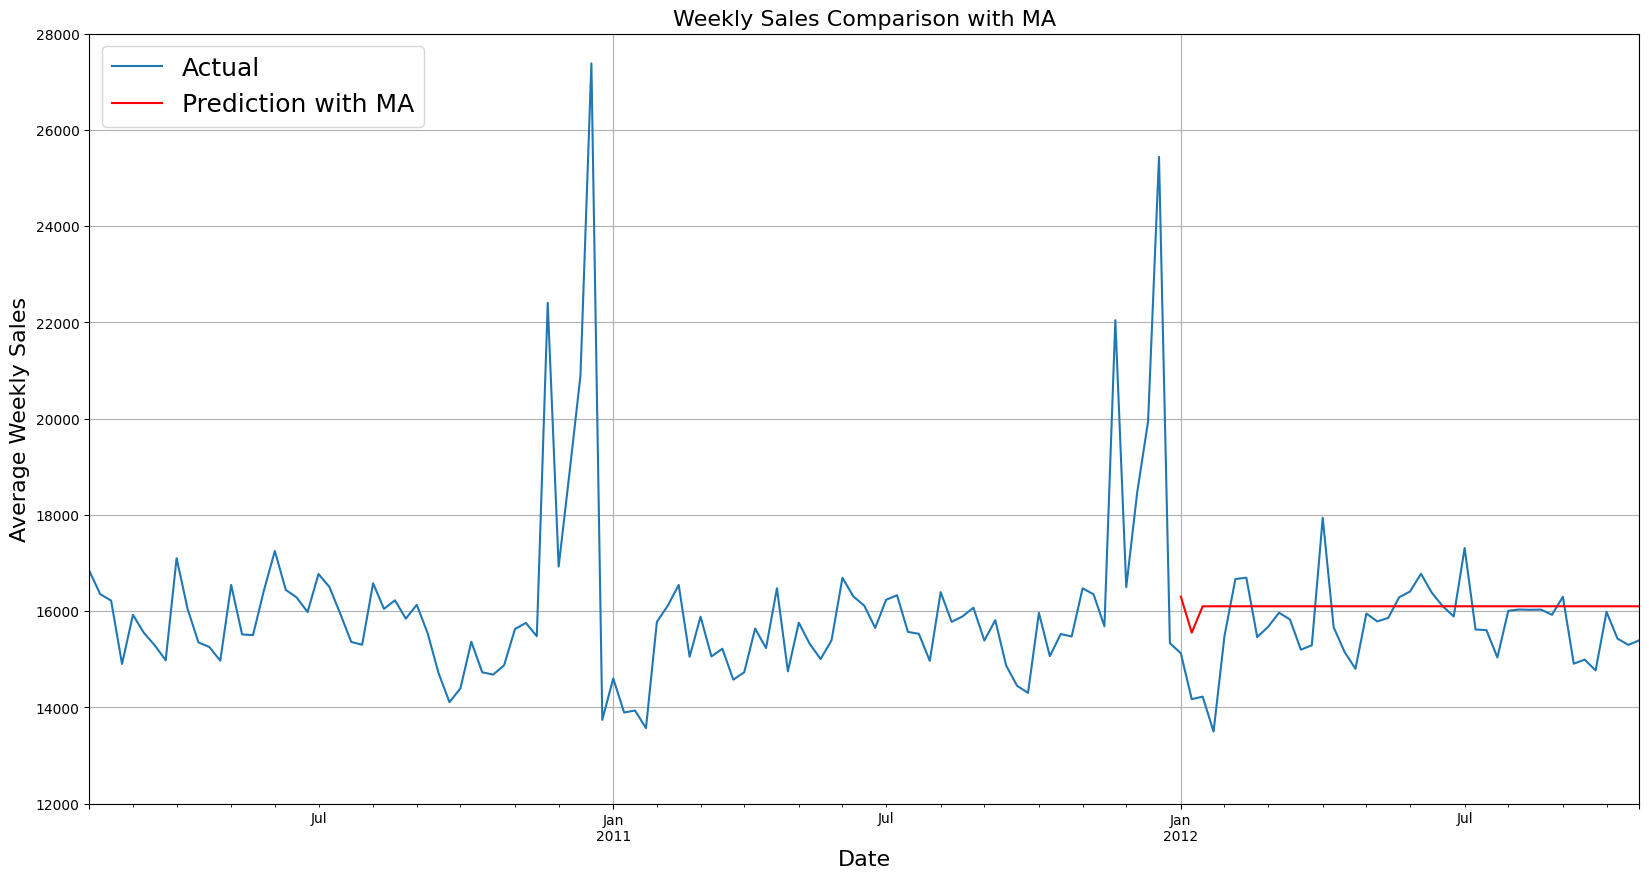

In [11]:
from statsmodels.tsa.arima.model import ARIMA

# Creating the MA model
model_ma = ARIMA(train_data, order=(0, 0, 2))  # Adjust the order parameter as needed
model_fit = model_ma.fit()
predictions_MA = model_fit.predict(start=100, end=142)

# Plotting
train_final1['Weekly_Sales'].plot(figsize=(20, 10))
predictions_MA.plot(color="r")

plt.legend(['Actual', 'Prediction with MA'], loc=2, fontsize=18)
plt.grid(True)

plt.title('Weekly Sales Comparison with MA', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Weekly Sales', fontsize=16)
plt.ylim(12000, 28000)
plt.show()

## Auto Regressive Integrated Moving Average (ARIMA)

In [12]:
#Creating the grid search for ARIMA
model_ARIMA = pm.auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=2, max_q=2, # maximum p and q
                      m=52,             # frequency of series
                      seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=False,stationary=True)

print(model_ARIMA.summary())

 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1812.876, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1807.819, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=1806.090, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1804.666, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1805.371, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=1807.867, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1803.956, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1805.975, Time=0.04 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1804.562, Time=0.14 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.386 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -897.978
Date:                Thu, 18 Apr 2024   AIC                           1803.956
Time:        

### ARIMA Diagnostics

<Figure size 1000x1000 with 0 Axes>

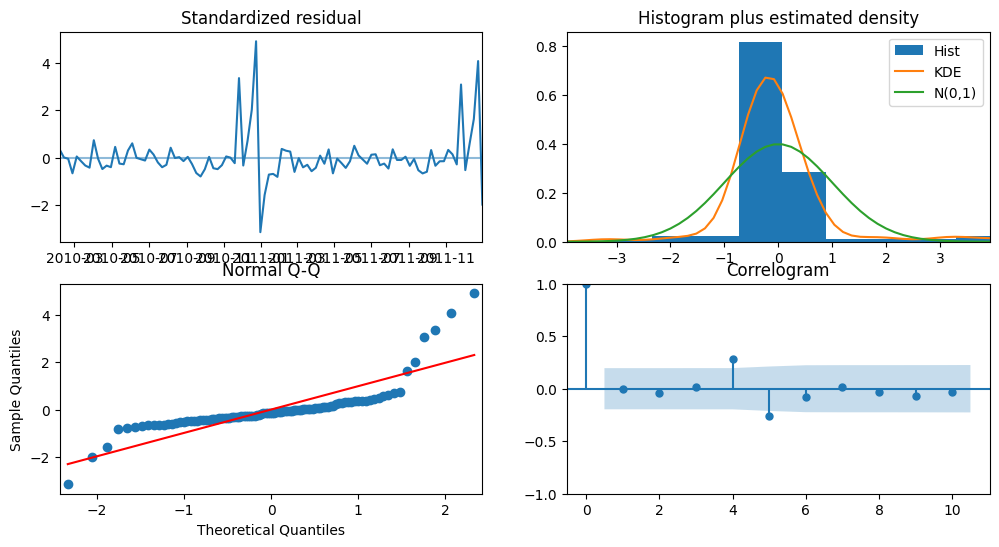

In [13]:
#Ploting the residual plots and ARIMA (2,0,0)
fig=plt.figure(figsize=(10,10))
fig=model_ARIMA.plot_diagnostics()
plt.show()

### Comparison of Actual and Predicted Value from ARIMA

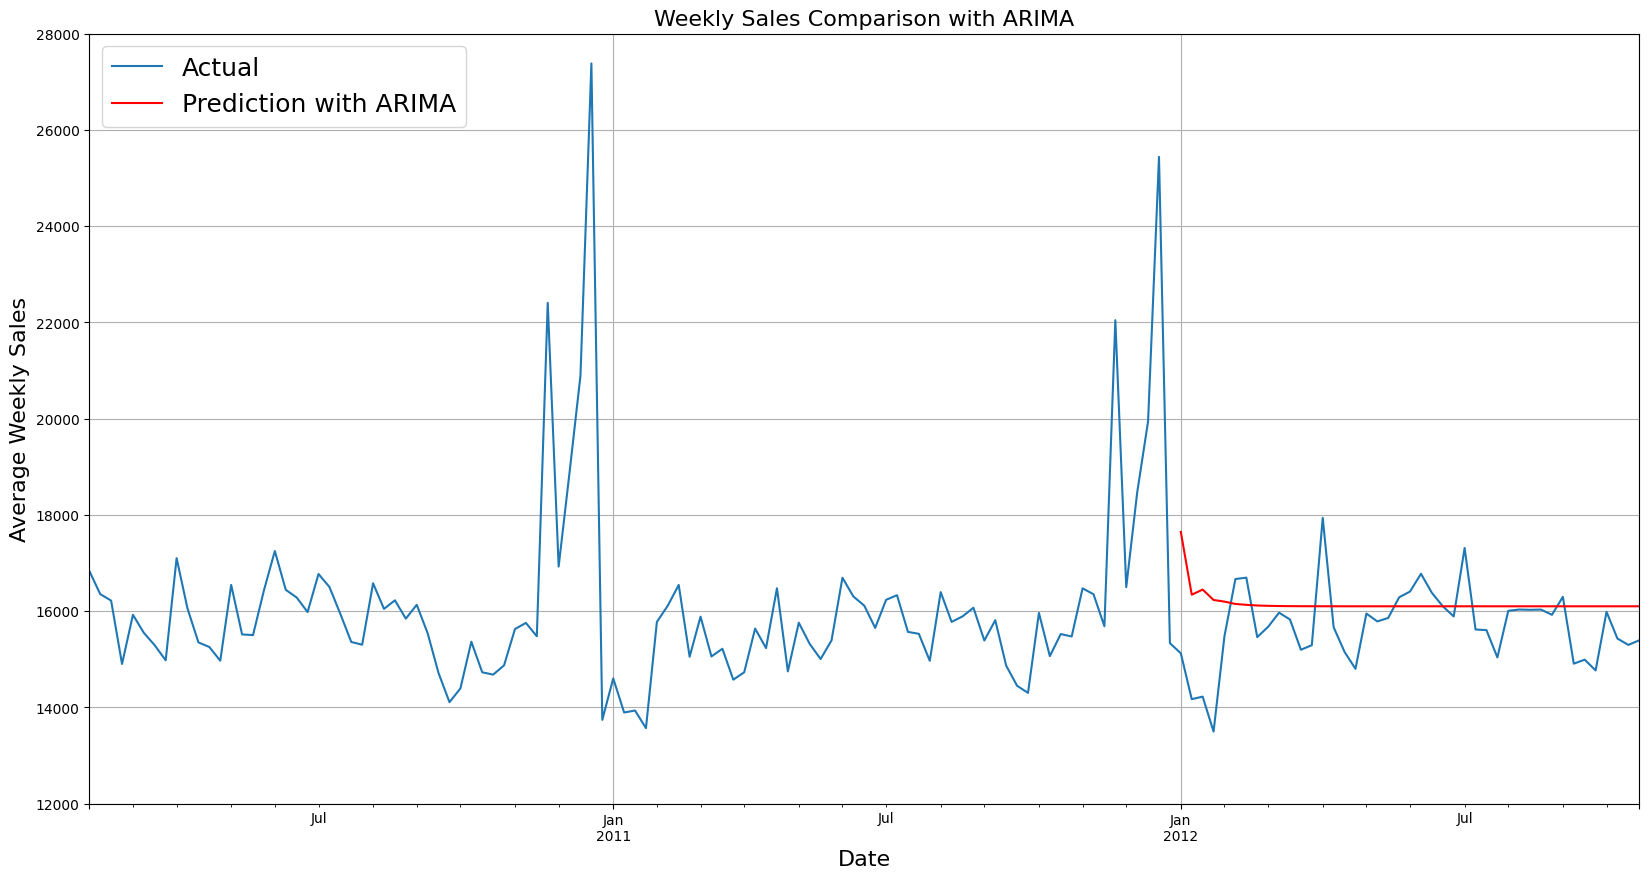

In [15]:
model_ARIMA = ARIMA(train_data, order=(2, 0, 0))
model_ARIMA_fit = model_ARIMA.fit()

fig, ax = plt.subplots()
ax = train_final1['Weekly_Sales'].plot(ax=ax)
predictions_ARIMA = model_ARIMA_fit.predict(start=100, end=142)
predictions_ARIMA.plot(figsize=(20, 10), color='r')

plt.legend(['Actual', 'Prediction with ARIMA'], loc=2, fontsize=18)
plt.grid(True)
plt.title('Weekly Sales Comparison with ARIMA', fontsize=16)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Average Weekly Sales', fontsize=16)
plt.ylim(12000, 28000)

plt.show()

## Seasonal Auto Regressive Integrated Moving Average (SARIMA)

In [16]:
#Grid search for the parameters for SARIMA
model_SARIMA = pm.auto_arima(train_data,
                           m=52,
                           seasonal=True,
                           max_p=2, max_q=2, max_d=2,
                           d=None, D=None, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True,staionary=True)
print(model_SARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=1775.424, Time=2.84 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=1812.876, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=1791.092, Time=0.73 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2224.689, Time=0.00 sec
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=inf, Time=2.15 sec
 ARIMA(2,0,2)(1,0,0)[52] intercept   : AIC=1774.054, Time=2.32 sec
 ARIMA(2,0,2)(0,0,0)[52] intercept   : AIC=1804.562, Time=0.13 sec
 ARIMA(2,0,2)(2,0,0)[52] intercept   : AIC=1775.972, Time=14.97 sec
 ARIMA(2,0,2)(2,0,1)[52] intercept   : AIC=1778.506, Time=17.53 sec
 ARIMA(1,0,2)(1,0,0)[52] intercept   : AIC=1777.136, Time=2.05 sec
 ARIMA(2,0,1)(1,0,0)[52] intercept   : AIC=1776.471, Time=1.89 sec
 ARIMA(1,0,1)(1,0,0)[52] intercept   : AIC=1779.688, Time=2.02 sec
 ARIMA(2,0,2)(1,0,0)[52]             : AIC=inf, Time=nan sec

Best model:  ARIMA(2,0,2)(1,0,0)

### SARIMA Diagnostics

<Figure size 1000x1000 with 0 Axes>

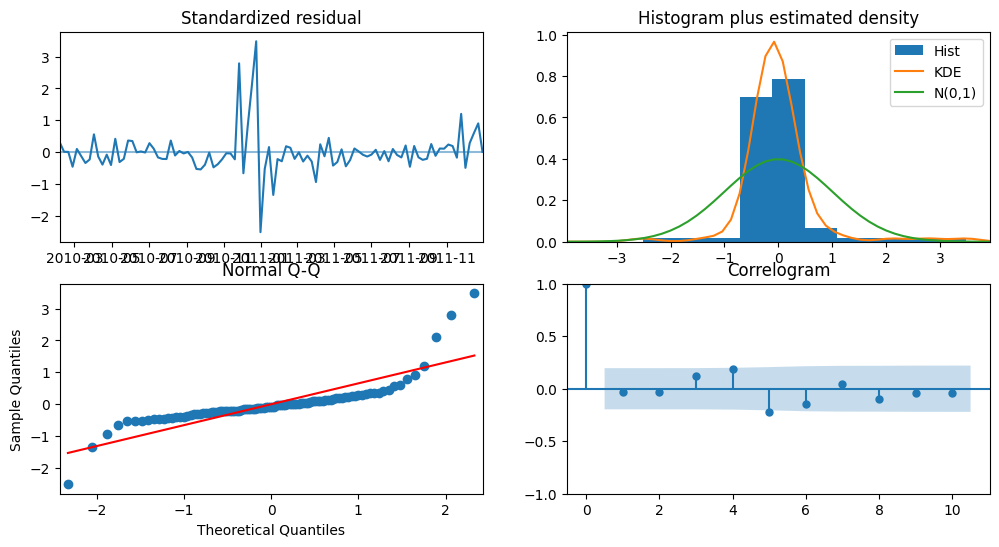

In [17]:
#Plotting residual plots for SARIMA (1,0,2)x(1,0,1,52)
fig=plt.figure(figsize=(10,10))
model_SARIMA.plot_diagnostics()
plt.show()

### Comparison of Actual and Predicted Value from SARIMA

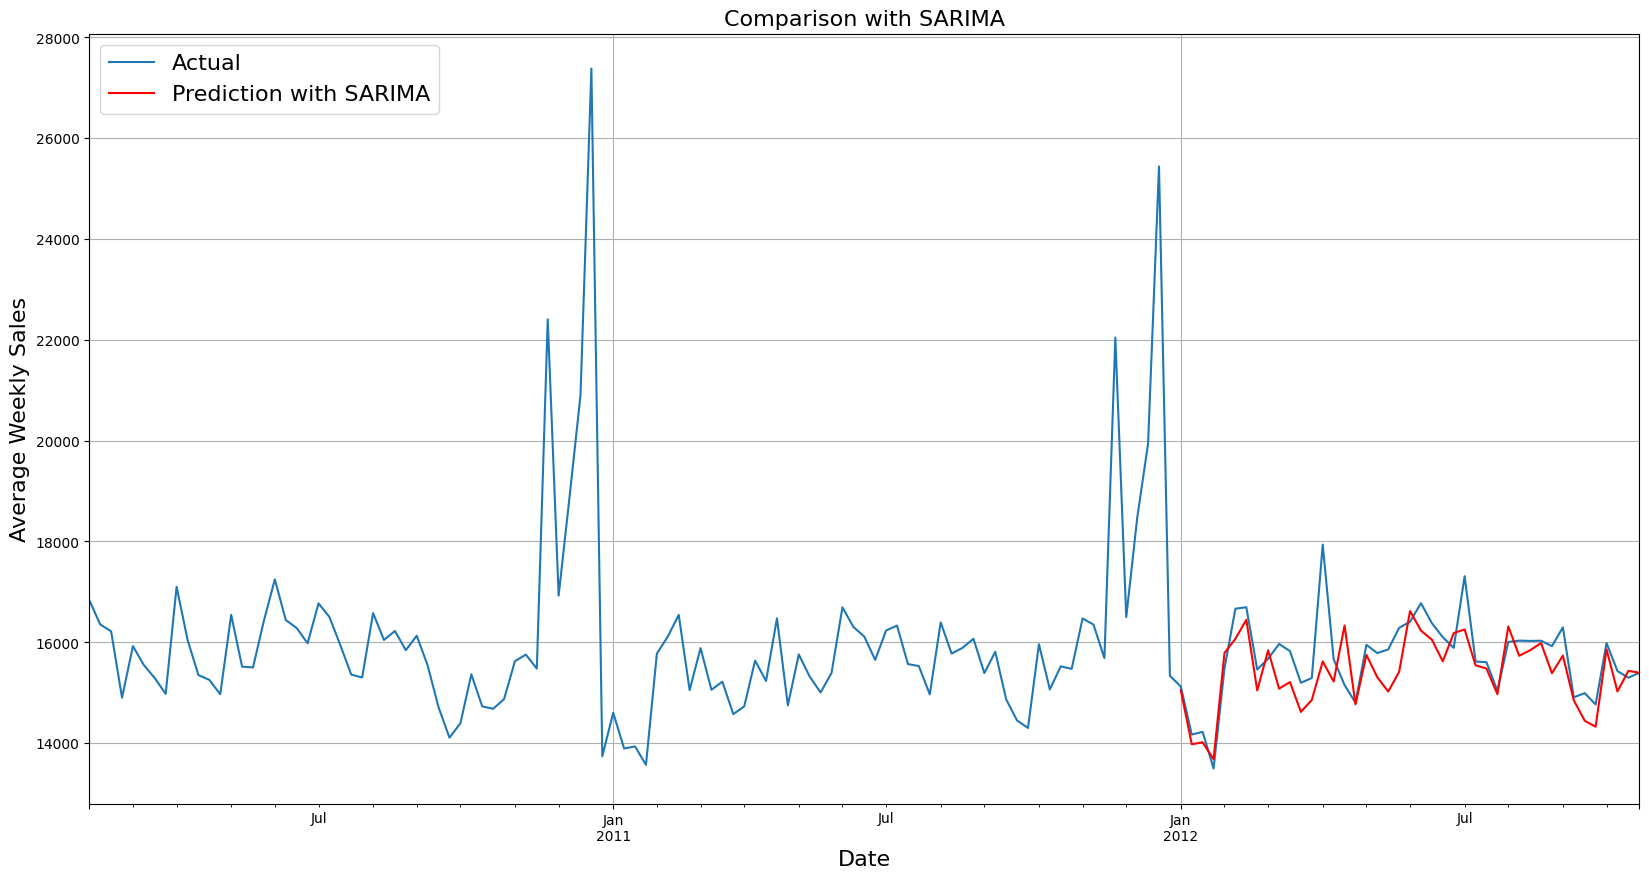

In [18]:
#Comparing the actual and predicted value from the SARIMA model (1,0,2)x(1,0,1,52)
model_SARIMA = SARIMAX(train_data, order=(1, 0, 2), seasonal_order=(1,0,1,52))
model_SARIMA_fit = model_SARIMA.fit(disp=False)

fig,ax=plt.subplots()
ax=train_final1.Weekly_Sales.plot(ax=ax)

predictions_SARIMA=model_SARIMA_fit.predict(start=100,end=142)
predictions_SARIMA.plot(figsize=(20,10),color='r')

plt.legend(['Actual','Prediction with SARIMA'],loc=2,fontsize=16)
plt.title('Comparison with SARIMA',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.ylabel('Average Weekly Sales',fontsize=16)
plt.grid(True)
plt.show()

## Holt-Winters Method Model

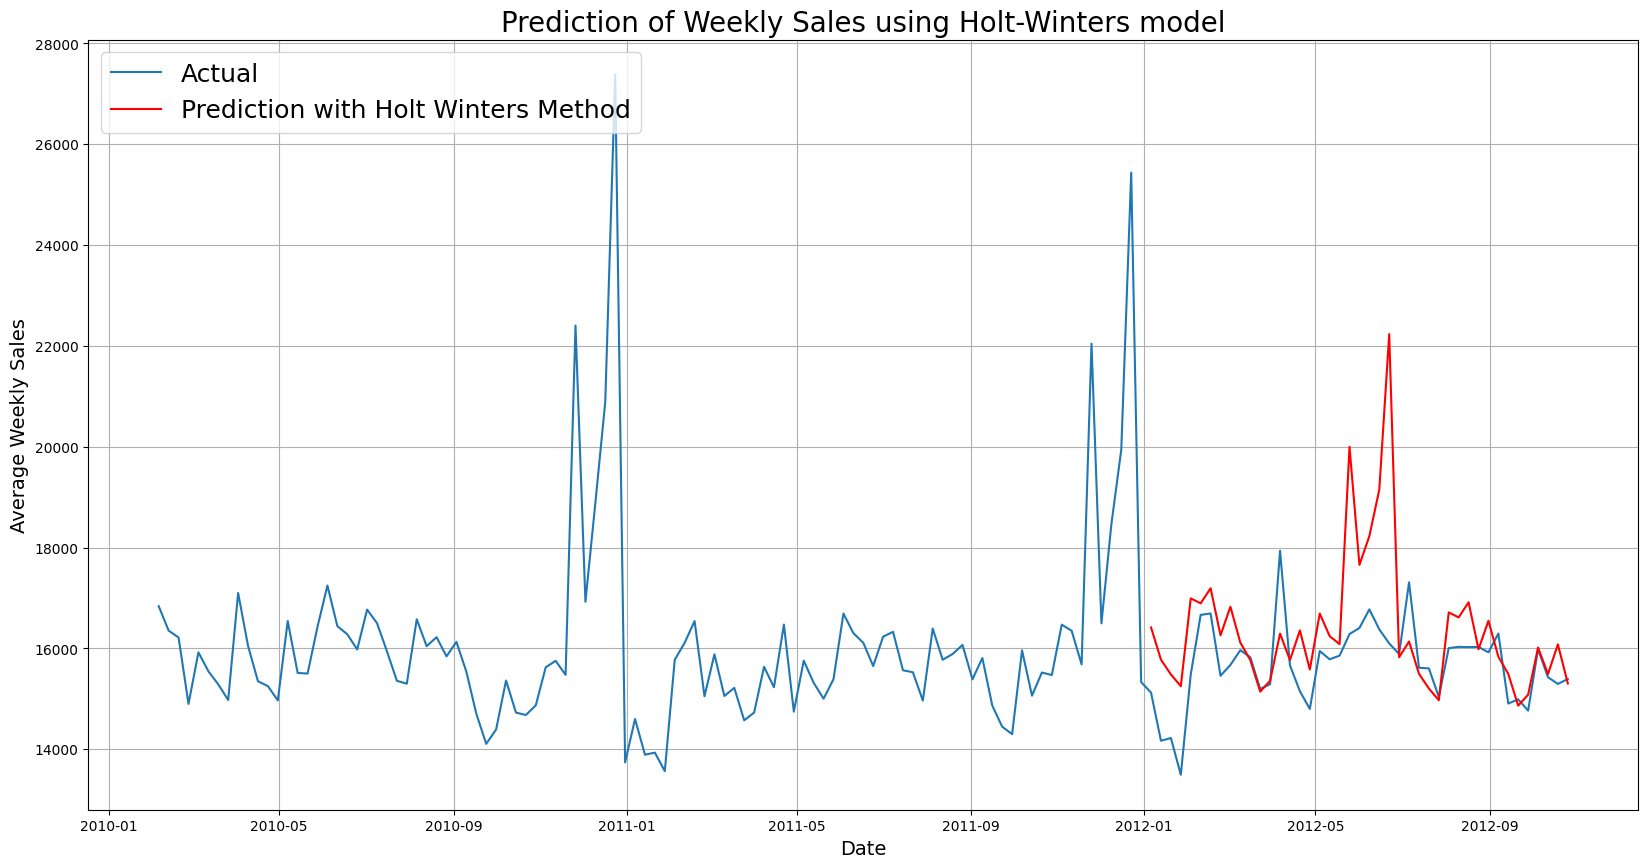

In [21]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_holt_winters = ExponentialSmoothing(train_data, seasonal_periods=26, trend='mul', seasonal='add').fit() 
prediction_Holt = model_holt_winters.predict(start=100, end=142)

plt.figure(figsize=(20, 10))
plt.title('Prediction of Weekly Sales using Holt-Winters model', fontsize=20)
plt.plot(train_final1['Weekly_Sales'], label='Actual')
plt.plot(prediction_Holt, label='Prediction with Holt Winters Method', color='r')

plt.legend(loc=2, fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Weekly Sales', fontsize=14)
plt.grid(True)
plt.show()